In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
### UTILITY FUNCTIONS TO FIT A LINEAR MODEL WHICH PREDICTS UNCERTAINTY ###

def loss(pred_mu, pred_sigma, true):
    return np.mean(2*pred_sigma + np.square((true-pred_mu)/np.exp(pred_sigma)))


def get_sigma_model(coefs):
        
    intercept = coefs[-1]
    coefs = coefs[:-1]
    
    sigma_model =  Ridge()
    sigma_model.coef_ = coefs
    sigma_model.intercept_ = intercept 
    
    return sigma_model
    

def min_fun(coefs, X, pred_mu, y):
    
    sigma_model = get_sigma_model(coefs)
    pred_sigma = sigma_model.predict(X) 
    
    return loss(pred_mu, pred_sigma, y)

In [3]:
### GENERATE SIMULATED DATA ###

def sim_data(data, scale=10, return_noise=True):
    
    stds = (0.15 / (1.0 + np.exp(-data))).clip(0)
    noise = np.random.normal(0, stds)
    data = (np.sin(data) + noise) *scale
    
    if return_noise:
        return data, noise
    return data


X_train = np.linspace(-4.0, 4.0, num=1200).reshape((-1, 1))
X_test = np.linspace(-7.0, 7.0, num=200).reshape((-1, 1))

y_train, _ = sim_data(X_train.ravel())
y_test, y_noise = sim_data(X_test.ravel())

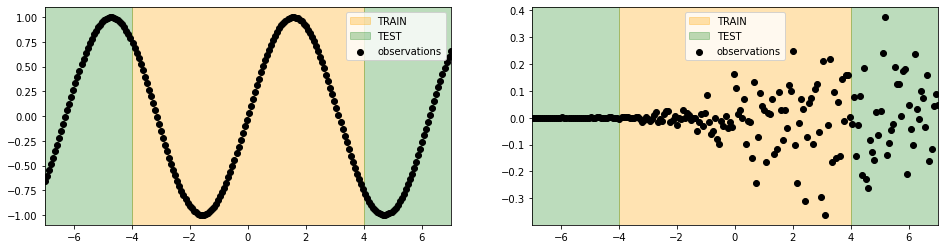

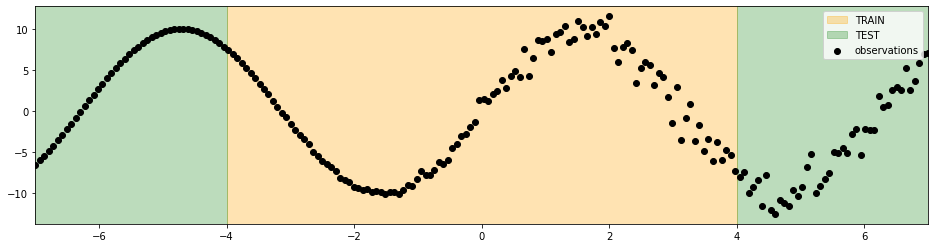

In [4]:
### PLOT SIMULATED DATA ###

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.xlim(X_test.min(), X_test.max())
plt.axvspan(X_train.min(), X_train.max(), alpha=0.3, color='orange', label='TRAIN')
plt.axvspan(X_train.max(), X_test.max(), alpha=0.3, color='forestgreen', label='TEST')
plt.axvspan(X_test.min(), X_train.min(), alpha=0.3, color='forestgreen')
plt.scatter(X_test, y_test/10-y_noise, color='black', label='observations')
plt.legend()
plt.subplot(1,2,2)
plt.xlim(X_test.min(), X_test.max())
plt.axvspan(X_train.min(), X_train.max(), alpha=0.3, color='orange', label='TRAIN')
plt.axvspan(X_train.max(), X_test.max(), alpha=0.3, color='forestgreen', label='TEST')
plt.axvspan(X_test.min(), X_train.min(), alpha=0.3, color='forestgreen')
plt.scatter(X_test, y_noise, color='black', label='observations')
plt.legend()

plt.figure(figsize=(16,4))
plt.xlim(X_test.min(), X_test.max())
plt.axvspan(X_train.min(), X_train.max(), alpha=0.3, color='orange', label='TRAIN')
plt.axvspan(X_train.max(), X_test.max(), alpha=0.3, color='forestgreen', label='TEST')
plt.axvspan(X_test.min(), X_train.min(), alpha=0.3, color='forestgreen')
plt.scatter(X_test, y_test, color='black', label='observations')
plt.legend()

plt.show()

In [5]:
### DEFINE A BASE MODEL USED TO PREDICT MU ###

base_mu_model = MLPRegressor(
    max_iter=500, hidden_layer_sizes=(32,32,)
)

In [6]:
### PREDICT MU ON TRAIN DATA ###

mu_model = base_mu_model.fit(X_train,y_train)
pred_mu = mu_model.predict(X_train)

In [7]:
### FIT SIGMA MODEL ON TRAIN DATA ###

x0_coef = np.ones((2,))
res_min = minimize(min_fun, x0_coef, 
                   args=(X_train, pred_mu, y_train), 
                   options={'maxiter':10_000})

sigma_model = get_sigma_model(res_min.x)

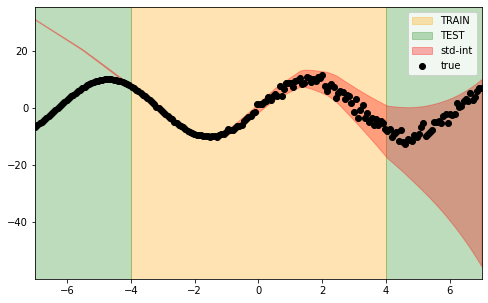

In [8]:
### PLOT SIGMA PREDICTIONS ###

pred_sigma1 = np.exp(sigma_model.predict(X_test)) 
pred_mu = mu_model.predict(X_test)

plt.figure(figsize=(8,5))
plt.axvspan(X_train.min(), X_train.max(), alpha=0.3, color='orange', label='TRAIN')
plt.axvspan(X_train.max(), X_test.max(), alpha=0.3, color='forestgreen', label='TEST')
plt.axvspan(X_test.min(), X_train.min(), alpha=0.3, color='forestgreen')
plt.xlim(X_test.min(), X_test.max())
plt.fill_between(X_test.ravel(), 
                 pred_mu + pred_sigma1*3, pred_mu - pred_sigma1*3,
                 alpha=0.3, color='red', label='std-int')
plt.scatter(X_test, y_test, color='black', label='true')
plt.legend()
plt.show()

In [9]:
### PREDICT MU ENSEBLES ON TRAIN DATA ###

mu_model = BaggingRegressor(
    base_mu_model, n_jobs=-1,
    max_samples=1., n_estimators=30
).fit(X_train,y_train)

pred_mu = mu_model.predict(X_train)

In [10]:
### FIT SIGMA MODELS ON TRAIN DATA ###

x0_coef = np.ones((2,))
res_min = [
    minimize(min_fun, x0_coef, 
             args=(X_train, m.predict(X_train), y_train), 
             options={'maxiter':10_000}).x
    for m in mu_model.estimators_
]

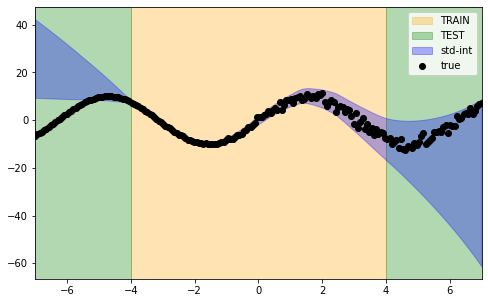

In [11]:
### PLOT SIGMA PREDICTIONS ###

pred_vars = np.stack([
    np.square(np.exp(get_sigma_model(coef).predict(X_test)))
    for coef in res_min
], axis=1)

pred_mus = np.stack([mu.predict(X_test) for mu in mu_model.estimators_], axis=1)
pred_mu = np.mean(pred_mus, axis=1)
pred_var = np.mean(pred_vars + np.square(pred_mus), axis=1) - np.square(pred_mu)
pred_sigma2 = np.sqrt(pred_var.clip(1e-3))

plt.figure(figsize=(8,5))
plt.axvspan(X_train.min(), X_train.max(), alpha=0.3, color='orange', label='TRAIN')
plt.axvspan(X_train.max(), X_test.max(), alpha=0.3, color='green', label='TEST')
plt.axvspan(X_test.min(), X_train.min(), alpha=0.3, color='green')
plt.xlim(X_test.min(), X_test.max())
plt.fill_between(X_test.ravel(), 
                 pred_mu + pred_sigma2*3, pred_mu - pred_sigma2*3,
                 alpha=0.3, color='blue', label='std-int')
plt.scatter(X_test, y_test, color='black', label='true')
plt.legend()
plt.show()

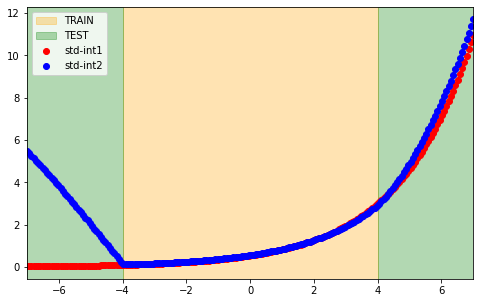

In [12]:
### COMPARE SIGMA INTERVAL WIDTHS ###

plt.figure(figsize=(8,5))
plt.axvspan(X_train.min(), X_train.max(), alpha=0.3, color='orange', label='TRAIN')
plt.axvspan(X_train.max(), X_test.max(), alpha=0.3, color='green', label='TEST')
plt.axvspan(X_test.min(), X_train.min(), alpha=0.3, color='green')
plt.xlim(X_test.min(), X_test.max())
plt.scatter(X_test, pred_sigma1, color='red', label='std-int1')
plt.scatter(X_test, pred_sigma2, color='blue', label='std-int2')
plt.legend()
plt.show()